# How to Kickoff Kickstarter

## Overview
Kickstarter is a crowdfunding site where anyone can start campaigns to receive funding from the general public for their creative projects. The site has an interesting dynamic because the creator only receives the funding if and when they reach their specified funding goal in their specified amount of time. So creators have to set a funding goal high enough to sufficiently fund their project but low enough to be achievable. They have to set a deadline far enough to reach their goal but close enough so they don't have to wait long to use the money. In this data analysis, we're going to explore what subtle factors could contribute to the success of a campaign and try to extract tips that can help you fund your own projects.

Note: when I refer to "goal" throughout this analysis, I am talking about the amount of money that the campaign is aiming to receive.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
ks = pd.read_csv("ks-projects-201801.csv")
ks.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01 03:43:57,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


By graphing main category on a count plot with a hue of state, we can see if and how success rates differ between the different project categories.

Text(0.5,1,'Number of projects in each category (split by status of project)')

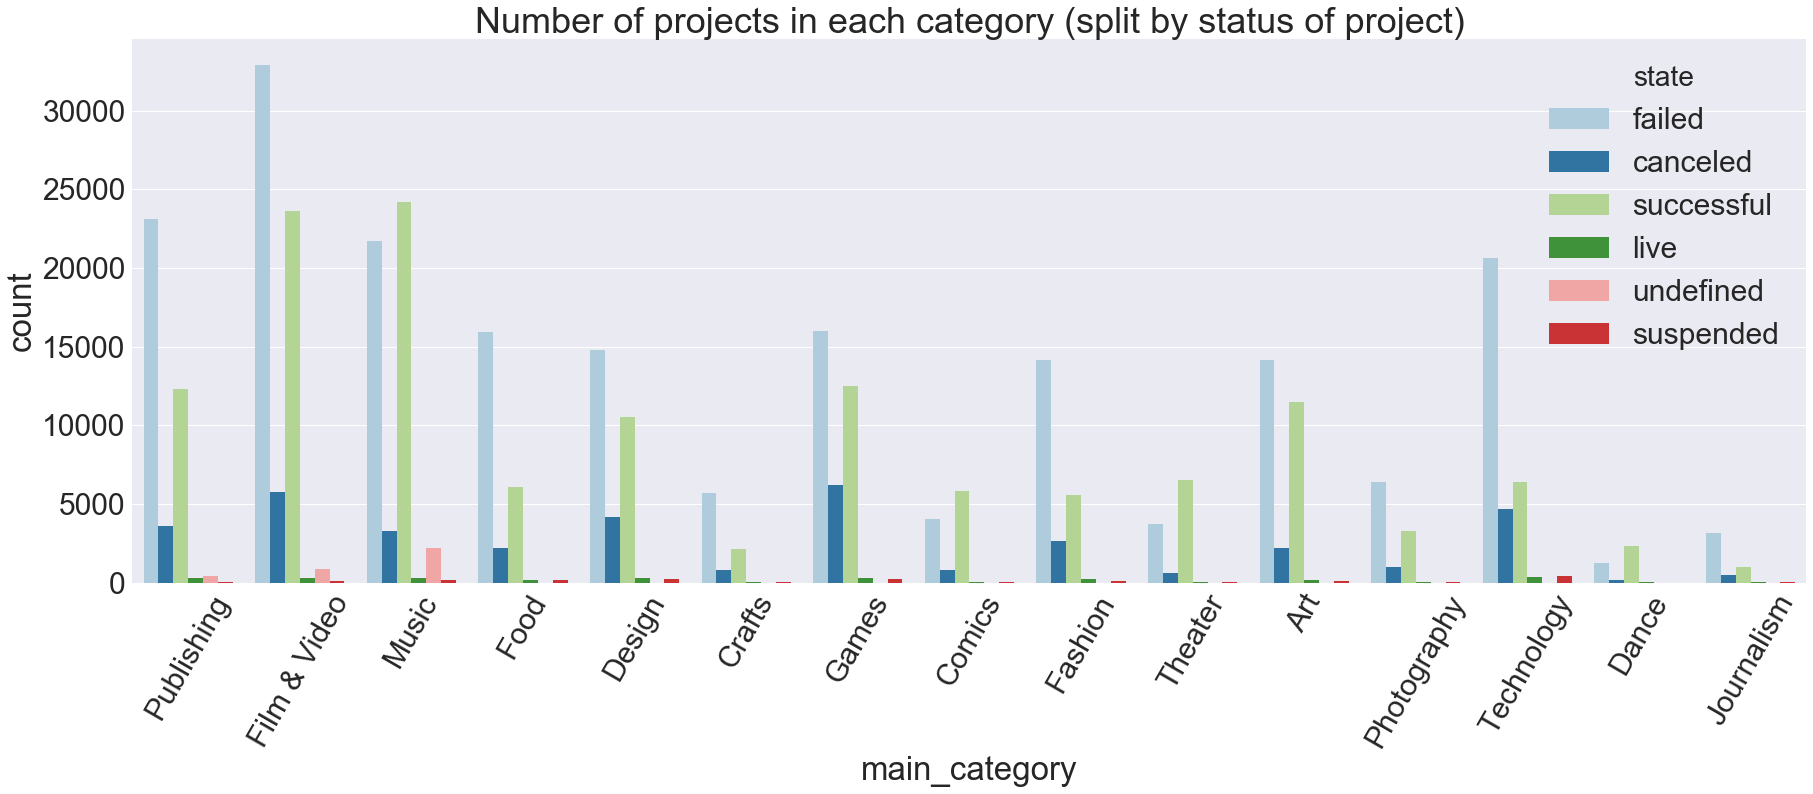

In [3]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
sns.countplot(x='main_category', data=ks, hue="state", palette="Paired")
plt.xticks(rotation=60)
plt.title("Number of projects in each category (split by status of project)")

It looks like the success rates definitely differ based on the category. For example, music projects seem to fair pretty well while technology projects fail more often. We can delve more into the reasons behind these differences. For example, do tech projects fail more because they tend to have higher funding goals, or is there something inherent that contributes to lower success rates?

First of all, we're going to drop projects from the data set that have a state of live, undefined, or suspended. These states seem too ambiguous to consider a success or failure. For the sake of this analysis, I'm also going to consider a canceled project a failure because in the majority of cases, a canceled project means that the creator did not believe they would reach their goal.

In [4]:
# removes ambiguous project states
ks.drop(ks[(ks.state == "live") | (ks.state == "undefined") | (ks.state == "suspended")].index, inplace=True )

In [5]:
def success(state):
    if state == "successful":
        return 1
    else:
        return 0

# creates a binary nominal variable column for success of a project
ks["successful"] = ks["state"].apply(success)

Text(0.5,1,'Number of projects in each category (split by status of project)')

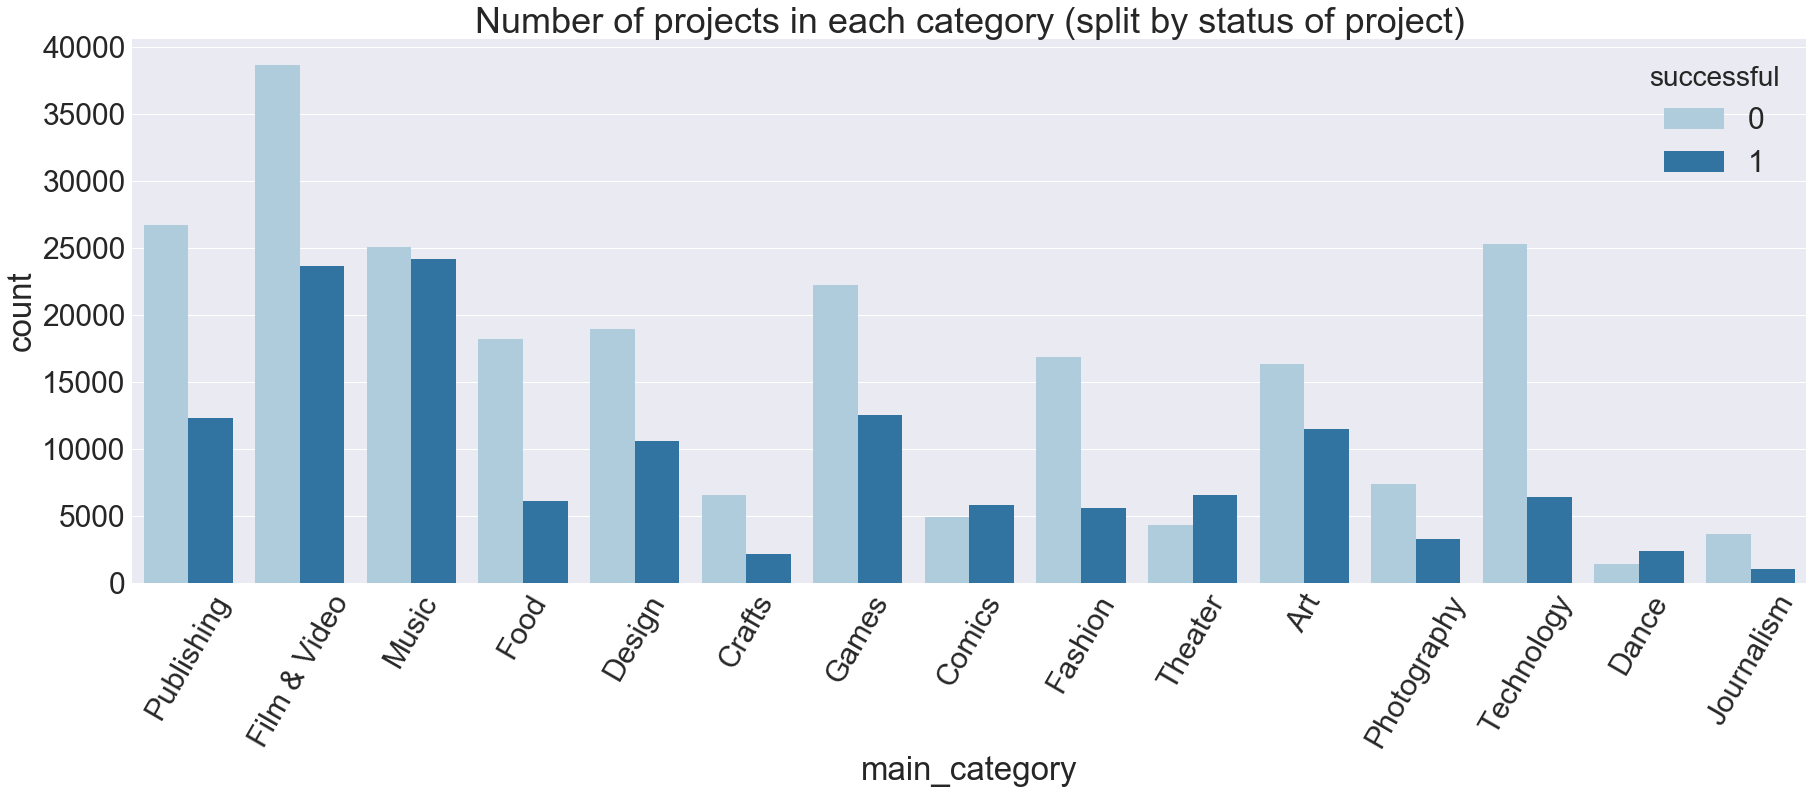

In [6]:
plt.figure(figsize=(30,10))
sns.set(font_scale=3)
sns.countplot(x='main_category', data=ks, hue="successful", palette="Paired")
plt.xticks(rotation=60)
plt.title("Number of projects in each category (split by status of project)")

We're also going to create a column in the data set for the funding period (in days) because the data set currently gives the launch date and the deadline date for each campaign. Projects that have a funding period exceeding 5000 days are removed from the data set because that means a period of over 13 years. Because creators only get the funds after the deadline is reached, people who have funding periods this long, I believe are either crazy or don't know how Kickstarter works.

In [7]:
# gets funding periods for the campaigns
fund_time = (pd.to_datetime(ks.deadline) - pd.to_datetime(ks.launched)).apply(lambda dt : dt.days + dt.seconds / (60 * 60 * 24))
ks['fund_time'] = fund_time
ks.drop(ks[ks.fund_time > 5000].index, inplace=True)

Text(0,0.5,'# of Projects')

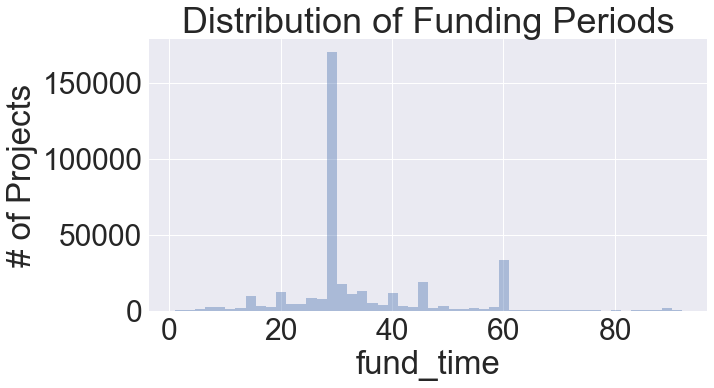

In [8]:
plt.figure(figsize=(10, 5))
sns.distplot(ks['fund_time'], kde=False)
plt.title("Distribution of Funding Periods")
plt.ylabel("# of Projects")

In [9]:
ks['fund_time'].value_counts().head()

30.000000    136667
60.000000     26518
45.000000     13709
29.958333     11276
30.041667     10717
Name: fund_time, dtype: int64

We can see that the most popular funding period is a month, which makes sense because that is the default when you create a new project on Kickstarter. Based on status quo bias, it makes sense that many people would stick to that month time frame. However, because many people choose that time frame without a reason beside it being a nice, round length of time and it being the default, I don't believe it is a good metric in determining the success of a project. As a result, it may be easier to analyze other features by keeping funding period constant, only looking at the campaigns lasting a month.

In [10]:
# removes projects that don't have a month time frame
ks = ks[(ks['fund_time'] > 29) & (ks['fund_time'] < 31)]

## Feature: Goal

Text(0,0.5,'# of Projects')

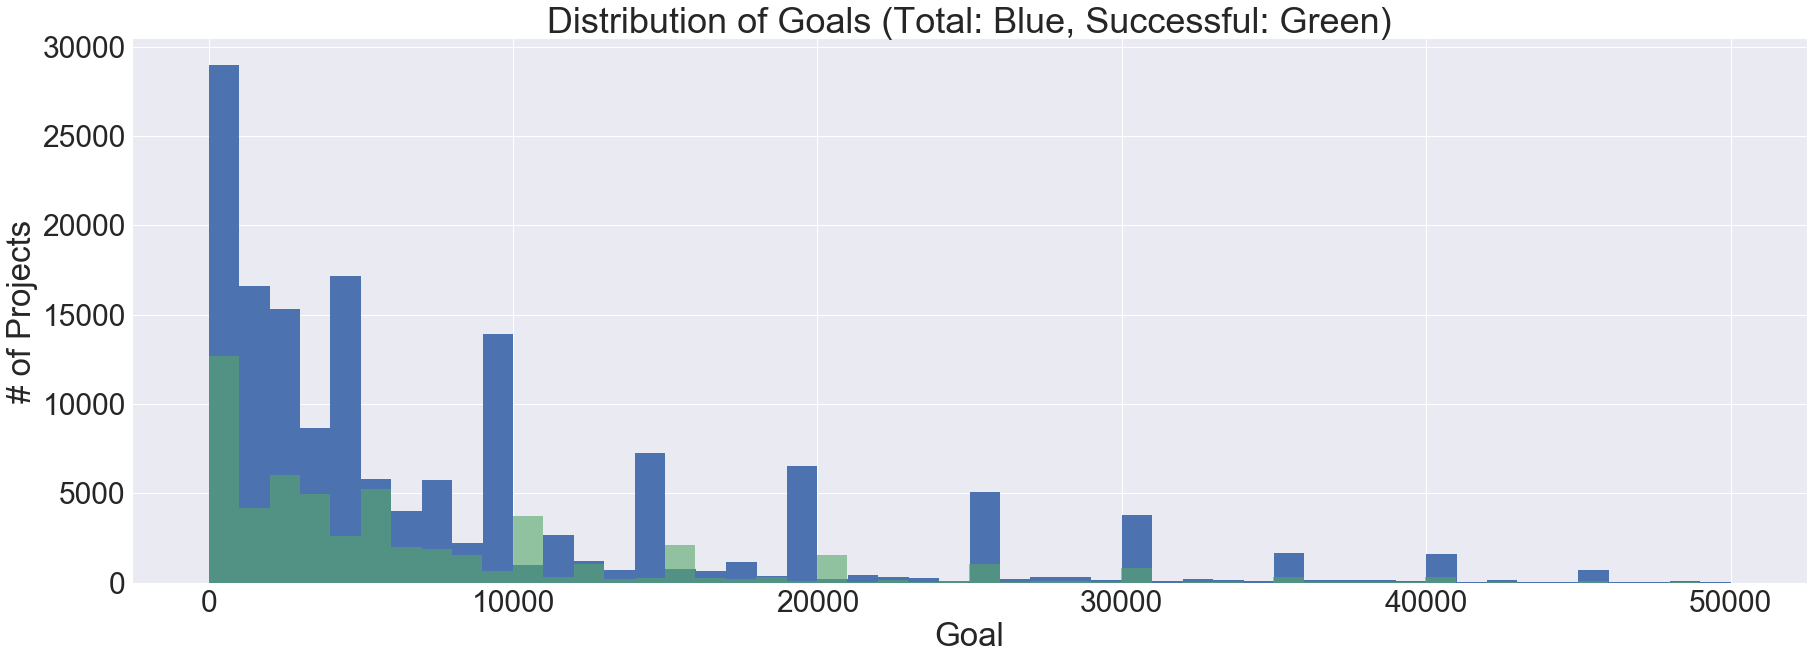

In [11]:
plt.figure(figsize=(30,10))
ks[ks.goal < 50000]['goal'].hist(bins=50)
ks[(ks.successful == 1) & (ks.goal < 50000)]['goal'].hist(bins=50, alpha=0.6)
plt.title("Distribution of Goals (Total: Blue, Successful: Green)")
plt.xlabel("Goal")
plt.ylabel("# of Projects")

Note: goal was limited to 50000 for graphing reasons

First of all, we notice the spikes in the histogram, which are most likely due to "nice" numbers like 10,000 dollars or 15,000 dollars being more popular. There's also a sort of exponentially decreasing trend for both the number of total campaigns and number of successful campaigns as the goal amount increases. From a quick glance, it also seems that **campaigns generally have higher success rates at lower goal values**, which makes sense because projects that don't ask for too much would intuitively be more successful.

Question: Why do some bins of the "successful" histogram surpass the corresponding bins of the "total" histogram? There can't be more successful projects than total projects. I think this is probably due to a difference in how the bins are split up for each histogram.

## Feature: Category

Text(0.5,1,'Category vs. Goal')

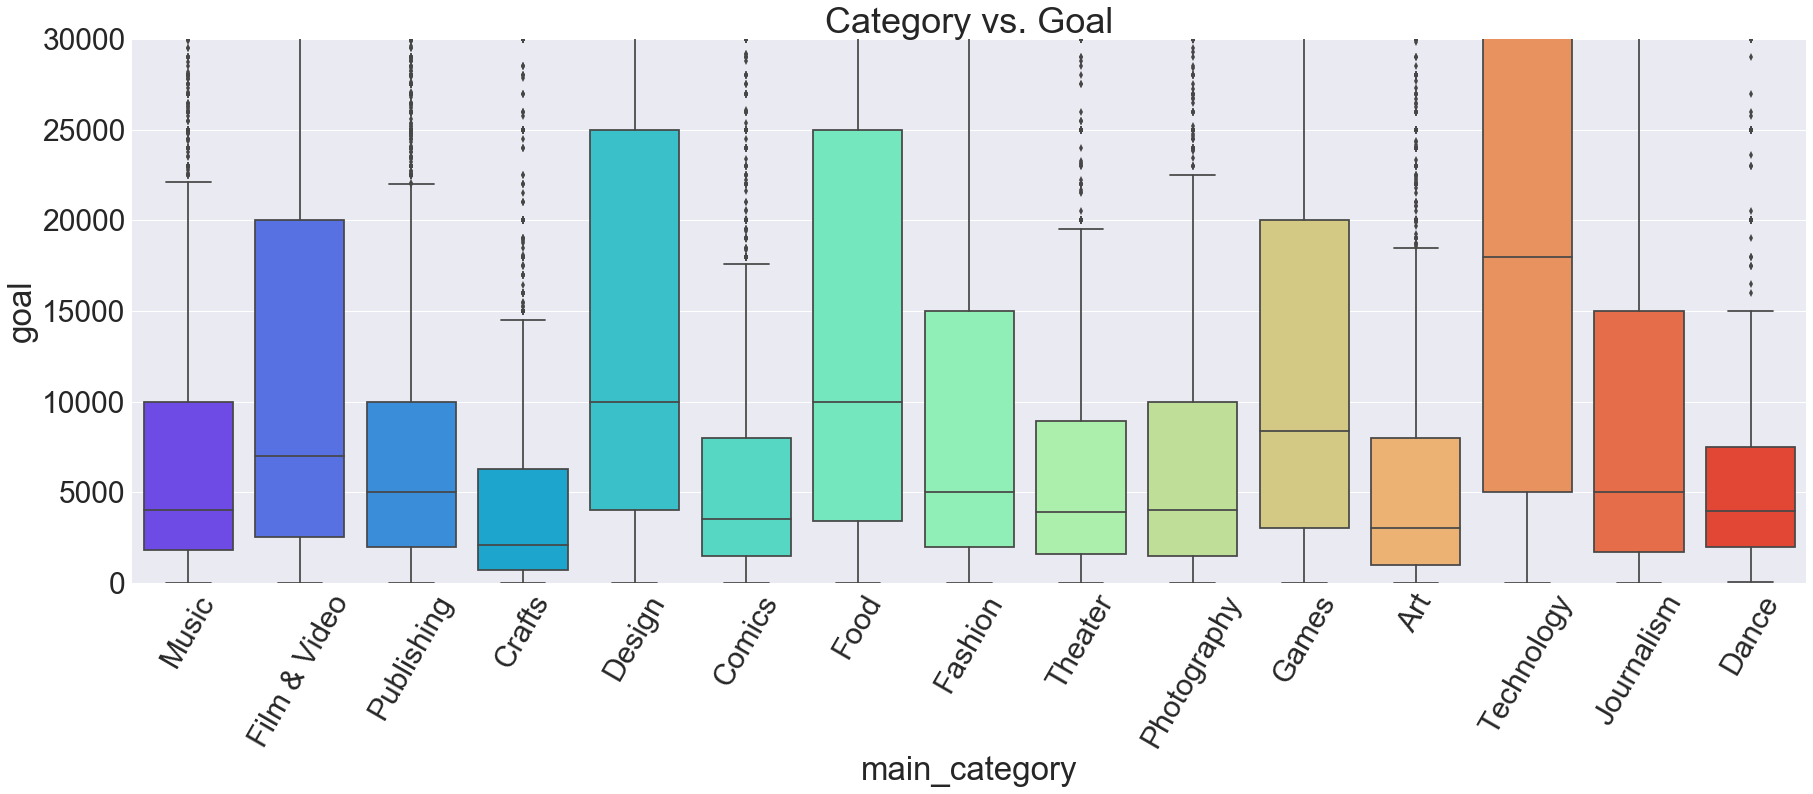

In [12]:
plt.figure(figsize=(30, 10))
sns.boxplot(x="main_category", y="goal", data=ks, palette="rainbow")
plt.ylim(0, 30000)
plt.xticks(rotation=60)
plt.title("Category vs. Goal")

I think a box plot works well for comparing category to goal because there are a lot of outliers with crazy high goal amounts, which could badly skew a graph dependent on the mean of the goals. Looking at this box plot, it's easy to visualize which categories of projects tend to have higher goal amounts. As we can see, technology generally has the highest goal values, and we saw while analyzing the goal feature, projects with higher goal values seem to have lower success rates. This result could explain some of the findings in graph Out[6].

I think now it would be interesting to compare the median goal values for the categories to the success rates for the categories as seen in graph Out[6].

In [13]:
# data frame of the median goals of the categories
cat_median = ks.groupby('main_category').median()['goal'].sort_values(ascending=False)
cat_med_df = pd.DataFrame({'main_category':cat_median.index, 'median':cat_median.values})

In [14]:
# data frame of the mean goals of the categories
cat_mean = ks.groupby('main_category').mean()['goal'].sort_values(ascending=False)
cat_mean_df = pd.DataFrame({'main_category':cat_mean.index, 'mean':cat_mean.values})

In [15]:
# series of the success rates of the categories
temp1 = ks.groupby('main_category').agg({'successful': 'sum', 'goal': 'count'})
cat_success_rate = temp1.successful / temp1.goal
sort_csr = cat_success_rate.sort_values()

Text(0.5,1,'Category vs. Median of Goals')

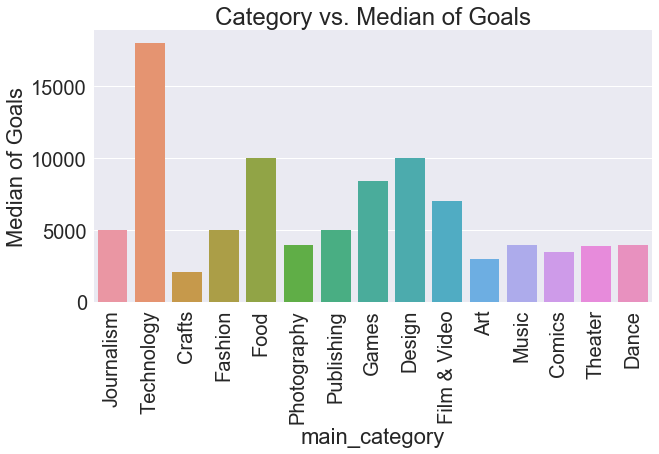

In [16]:
plt.figure(figsize = (10,5))
sns.set(font_scale=2)
sns.barplot(x="main_category", y="median", data=cat_med_df, order=['Journalism', 'Technology', 'Crafts', 'Fashion', 'Food', 'Photography',
       'Publishing', 'Games', 'Design', 'Film & Video', 'Art', 'Music',
       'Comics', 'Theater', 'Dance'])
plt.xticks(rotation=90)
plt.ylabel('Median of Goals')
plt.title('Category vs. Median of Goals')

Text(0.5,1,'Category vs. Mean of Goals')

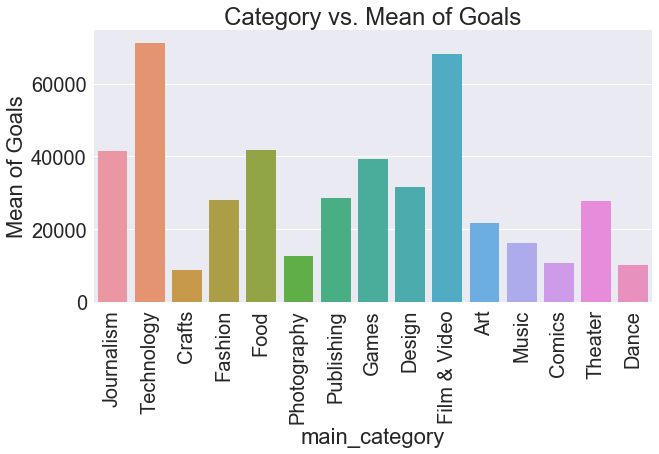

In [17]:
plt.figure(figsize = (10,5))
sns.set(font_scale=2)
sns.barplot(x="main_category", y="mean", data=cat_mean_df, order=['Journalism', 'Technology', 'Crafts', 'Fashion', 'Food', 'Photography',
       'Publishing', 'Games', 'Design', 'Film & Video', 'Art', 'Music',
       'Comics', 'Theater', 'Dance'])
plt.xticks(rotation=90)
plt.ylabel('Mean of Goals')
plt.title('Category vs. Mean of Goals')

Text(0.5,1,'Category vs. Success Rate')

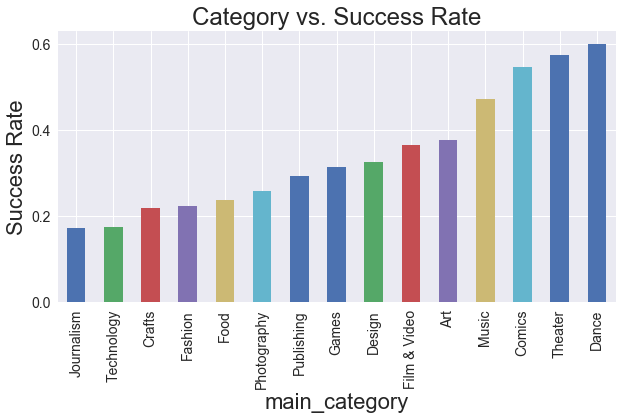

In [18]:
plt.figure(figsize = (10,5))
sort_csr.plot.bar(fontsize=14)
plt.ylabel("Success Rate")
plt.title("Category vs. Success Rate")

Note: I also analyzed category vs. mean of the goals in case it better matched the data for category vs. success rate.

So I'm actually pretty surprised. I thought that the goal category would be a better determiner of the success rates for the categories. If there was a strong relationship between the success rate and the funding goals of the category, then you would expect the bar plots for category vs. median/mean to have a decreasing trend because a lower success rate would correspond to higher funding goals for the category. However, the graphs for category vs. median/mean don't show any noticeable trends. This result doesn't mean the funding goals don't play a role in the success rates of the categories, but I believe it means that "category" is more of an independent feature and has more of its own inherent aspects for determining success than I thought.

As a result, I'm going to include the success rate rankings for the categories as a useful observation:

__Success Rate Rankings__
1) Dance
2) Theater
3) Comics
4) Music
5) Art
6) Film & Video
7) Design
8) Games
9) Publishing
10) Photography
11) Food
12) Fashion
13) Crafts
14) Technology
15) Journalism

However, I feel like it's still important to show the effect of the funding goal on success for each category.

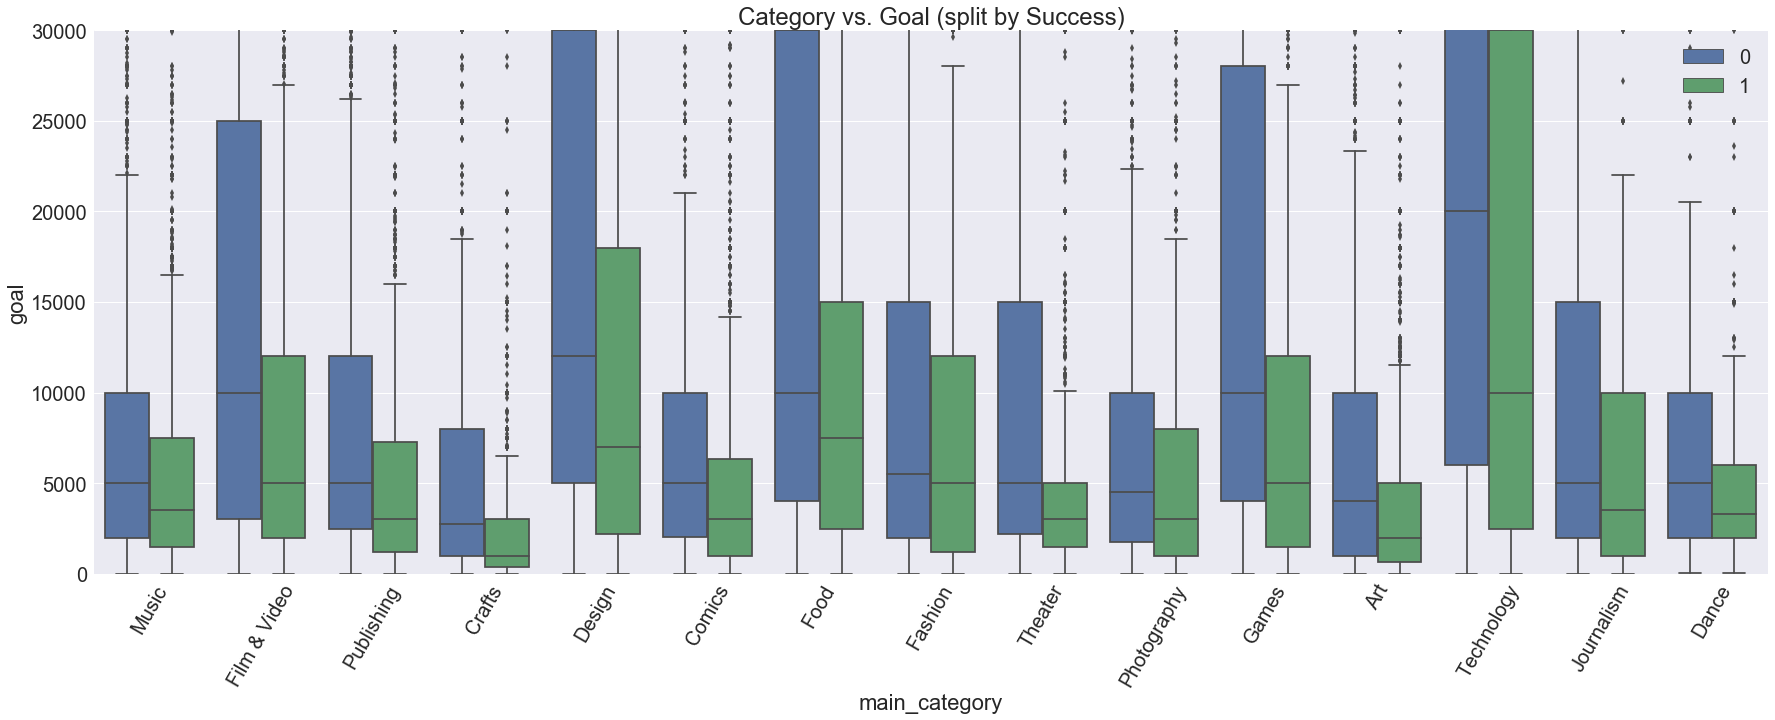

In [19]:
plt.figure(figsize=(30, 10))
sns.boxplot(x="main_category", y="goal", hue="successful", data=ks);
plt.ylim(0, 30000)
plt.xticks(rotation=60)
plt.title("Category vs. Goal (split by Success)")
plt.legend(loc=1)

Looking at this box plot, it's clear that for every category, successful projects (denoted by the green bars) are more likely for campaigns with lower funding goals. However, the reason this relationship does not show up as well in the graphs above is because the effect of lower goals on increasing success is not consistently strong between the categories. For example, "fashion" doesn't show a huge drop in funding goals for the successful projects, while "publishing" shows a more dramatic drop. The difference in this effect may be because of inherent qualities of the categories.

## Feature: Title Length

We've looked at the more obvious features like category and funding goal, but I'm curious whether there are more subtle features that can influence the success of a campaign. One of these features I'm thinking about is the length of your title. The reason is that with such a large amount of campaigns, the title may be a key component in determining whether a funder visits your project page.

In [20]:
ks['title_length'] = ks['name'].apply(lambda x : len(x))

Text(0.5,0.98,'Distribution of Length of Title (Total: Blue, Successful: Green)')

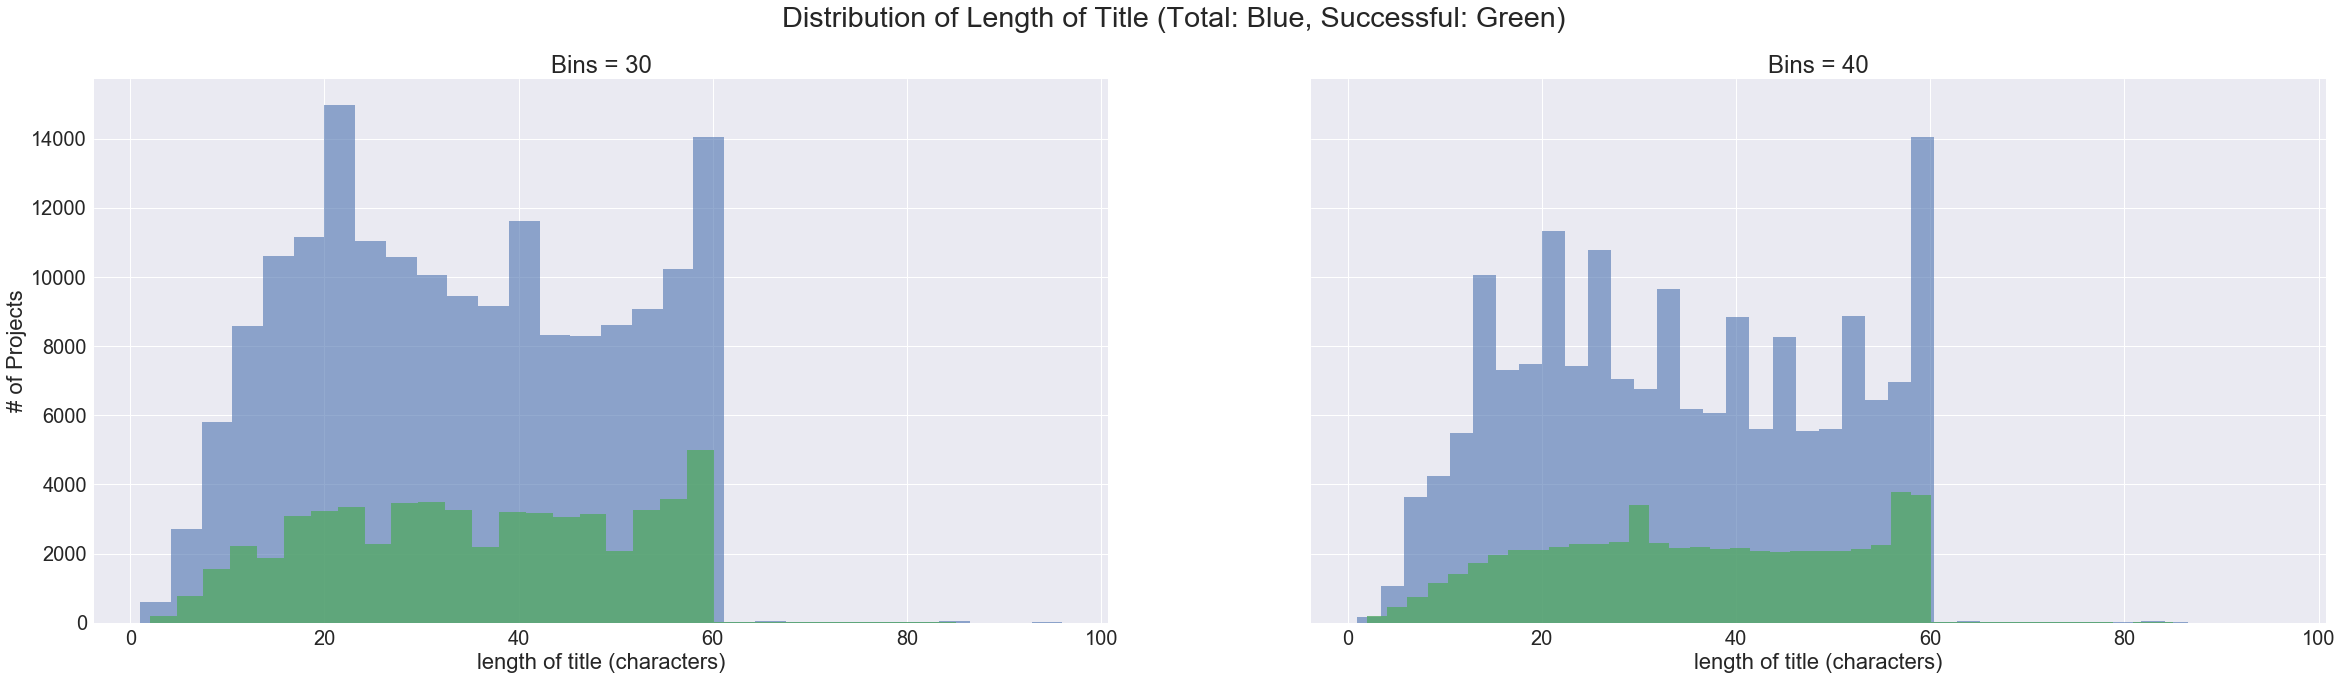

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.hist(x=ks['title_length'], bins=30, alpha=0.6)
ax1.hist(x=ks[ks.successful == 1]['title_length'], bins=30, alpha=0.8)
ax1.set_ylabel('# of Projects')
ax1.set_xlabel('length of title (characters)')
ax1.set_title('Bins = 30')
ax2.hist(x=ks['title_length'], bins=40, alpha=0.6)
ax2.hist(x=ks[ks.successful == 1]['title_length'], bins=40, alpha=0.8)
ax2.set_xlabel('length of title (characters)')
ax2.set_title('Bins = 40')
f.set_figheight(10)
f.set_figwidth(40)
plt.suptitle('Distribution of Length of Title (Total: Blue, Successful: Green)')

Note: same graph with different bin amounts to see the effect on graph visualization

The distribution for length of title is actually pretty interesting. Looking at all the projects, the distribution almost looks bimodal. However, the distribution for the successful projects has less fluctuation but an interesting spike near the character limit of 60. You could say that there's a spike because there's a local maxima for the total projects, but we don't see even close to that same spike happening at the other local maxima.

Let's split the dataset across the median for title length, so we can compare success rates for projects with title lengths in the lower half to those with title lengths in the upper half.

In [22]:
ks['title_length'].median()

33.0

In [23]:
# finds success rates per categories for projects with title lengths less than or equal to median title length
temp2 = ks[ks.title_length <= 32].groupby('main_category').agg({'successful': 'sum', 'goal': 'count'})
tl_success_rate_short = temp2.successful / temp2.goal
sort_tsr_short = tl_success_rate_short.sort_values()

In [24]:
# finds success rates per category for projects with title lengths longer than median title length
temp3 = ks[ks.title_length > 32].groupby('main_category').agg({'successful': 'sum', 'goal': 'count'})
tl_success_rate_long = temp3.successful / temp3.goal
sort_tsr_long = tl_success_rate_long.sort_values()

In [25]:
# data frame for percent increase between short title lengths --> longer title lengths
title_diff = (sort_tsr_long - sort_tsr_short) * 100.0
title_diff_df = pd.DataFrame({'main_category':title_diff.index, 'increase':title_diff.values})

Text(0.5,1,'Category vs. Success Rate Increase From "Short" Titles to "Long" Titles')

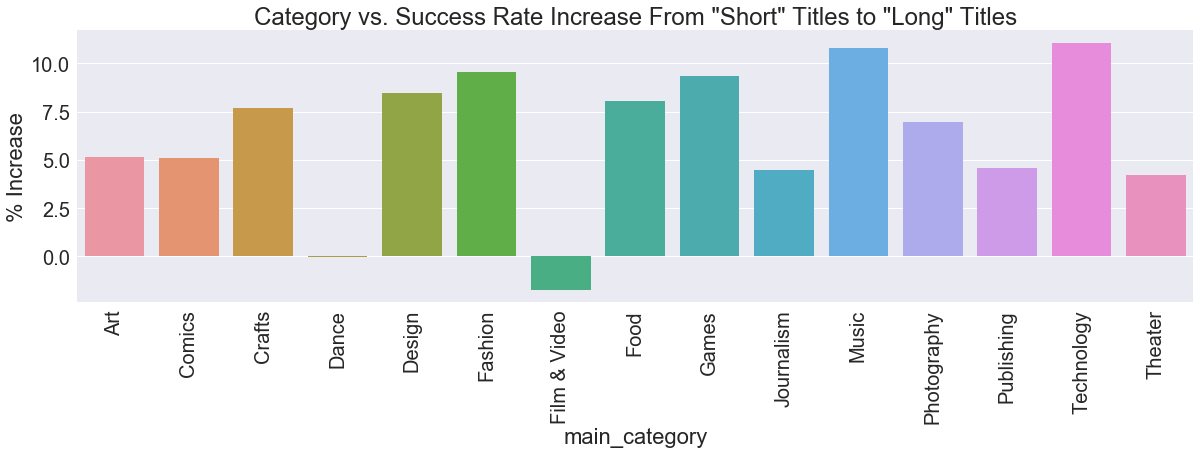

In [26]:
plt.figure(figsize = (20,5))
sns.set(font_scale=2)
sns.barplot(x="main_category", y="increase", data=title_diff_df)
plt.xticks(rotation=90)
plt.ylabel('% Increase')
plt.title('Category vs. Success Rate Increase From "Short" Titles to "Long" Titles')

The length of the title actually has a much larger effect on success rate than I would have guessed. Before doing any analysis on this feature, I would've said maybe a few percent increase, but across the categories, there are increases of five percent to over ten percent on the success rate. So in general, it seems that **campaigns with longer titles have an increased chance of success**. The Film & Video Category is an interesting exception. I feel like creators in this space can get away with having their campaign titles just be their film titles without any additional explanation. Shorter titles may even be more effective by creating a sense of mystery, enticing visitors to their page.

## Feature: Month of Campaign

The final feature I am going to observe is the time of year that the campaign takes place. Maybe people are more generous during certain seasons. For the sake of simplicitly, I'm going to deal with this time-of-year feature by just analyzing the month in which the project launches, even though projects start at different times in the month and overlap into other months.

In [27]:
# extract month from launch date
starting_month = (pd.to_datetime(ks.launched)).apply(lambda dt : dt.month)
ks['starting_month'] = starting_month

Text(0.5,1,'Distribution over Months of the Year (split by Success)')

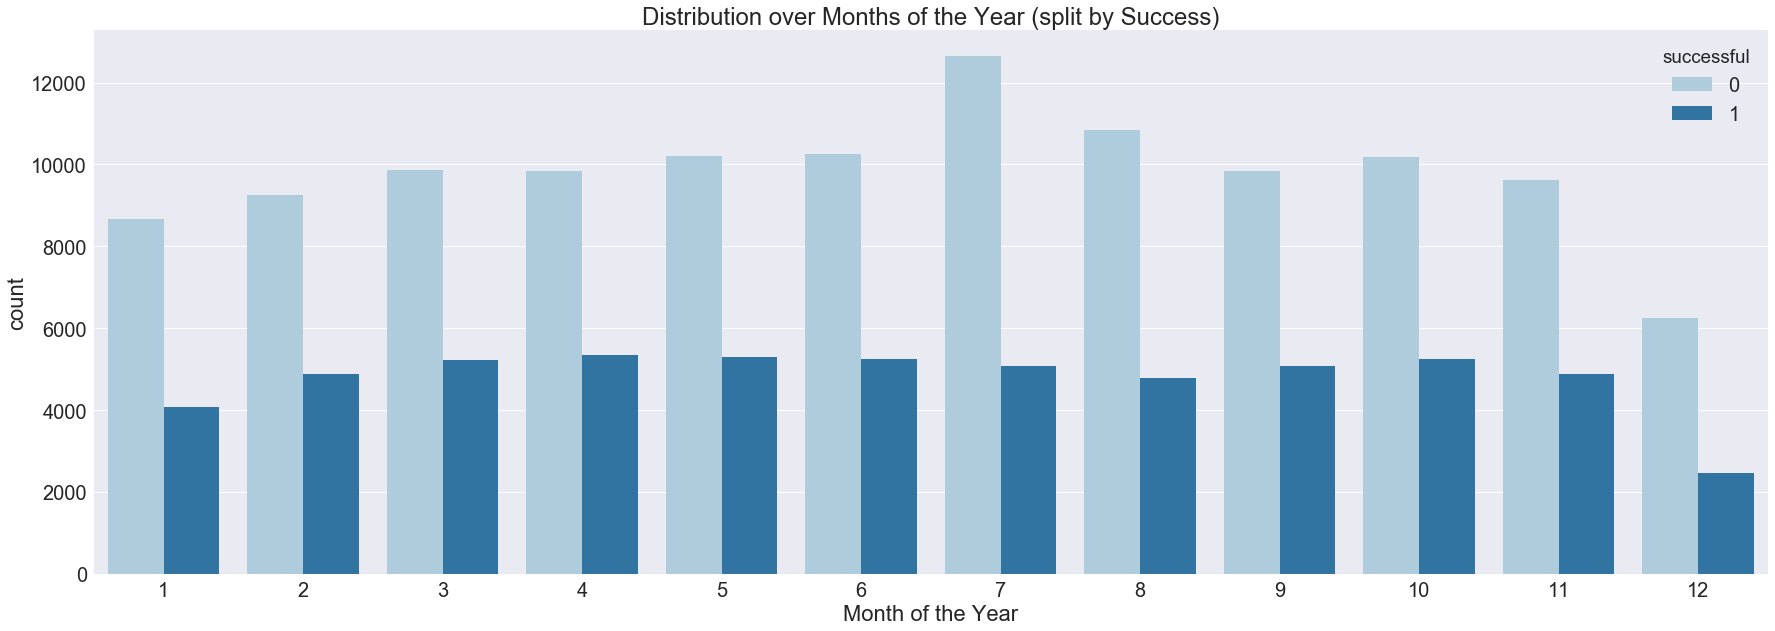

In [28]:
plt.figure(figsize=(30, 10))
sns.countplot(x='starting_month', data=ks, hue="successful", palette="Paired")
plt.xlabel('Month of the Year')
plt.title('Distribution over Months of the Year (split by Success)')

Just looking at the bar plot, some interesting points pop out. July seems like an awful month to launch a Kickstarter campaign. In December, the number of total projects decreases, which makes sense because people are busy during the holidays, but it's interesting that the holiday season doesn't appear to make funders more generous either.

Let's take a look at the success rates for each month.

In [29]:
# gets the success rates for each month
temp4 = ks.groupby('starting_month').agg({'successful': 'sum', 'goal': 'count'})
msr = temp4.successful / temp4.goal * 100
msr_df = pd.DataFrame({'starting_month': msr.index, 'success_rate': msr.values})

Text(0.5,1,'Month vs. Success Rate')

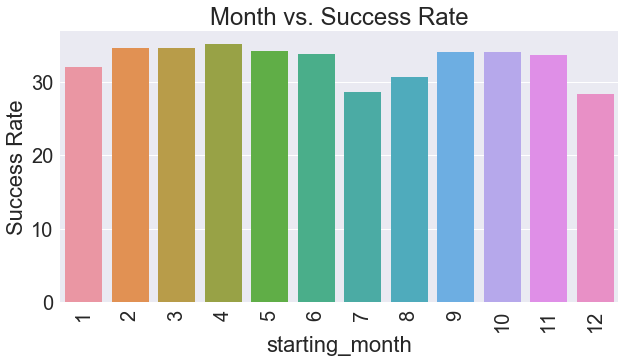

In [30]:
plt.figure(figsize = (10,5))
sns.set(font_scale=2)
sns.barplot(x="starting_month", y="success_rate", data=msr_df)
plt.xticks(rotation=90)
plt.ylabel('Success Rate')
plt.title('Month vs. Success Rate')

It seems like success rate stays pretty constant throughout the year. However, in both July and December, there is a dip in success rate of a few percent. This result is interesting because July has the greatest number of total projects while December has the least. I'm not sure about the demographics of Kickstarter creators, but maybe the increase in total projects is due to summer break, when college and high school students have time to post projects. However, just because there is an increase in projects doesn't mean there is an increase in people to fund these projects. And it's also possible that more projects means a greater diffusion of funds, so individual projects are less likely to concentrate enough funds to reach their goal. This theory might explain the slight dip in successful projects in the July and August months.

It's also pretty interesting that the time of the year with the least amount of projects also produces the lowest number of successful projects. There could be a lot of reasons for this dip. Maybe people use all their money during the holidays and have less to donate. Maybe people are just too busy to browse Kickstarter projects. Or maybe it's true that people become more selfish during the holidays. Whatever the case, the main takeaway is that if you want a slight bump in the success rate for your Kickstarter, **avoid starting your campaign in the months of July and December**.

# Conclusion and Takeaways

This analysis of the Kickstarter data led to some interesting observations. Here are some of the key takeaways that I think can help someone find success in their own Kickstarter campaign:
<br>
1. **Go cheap**
<br>
I think there's an impression that Kickstarter projects have to be somewhat grand and revolutionary to attract attention and be successful. However, as you saw from the data, it's the humble projects that don't ask for a lot that are more likely to reach their goal. So even if you think no one would care to fund your acapella cover of Darude Sandstorm, it doesn't hurt to try.
2. **Projects don't have equal rights**
<br>
Even if you control for differences in funding goal, projects in certain categories are more likely to be funded than projects in others. Here are the success rates ranking that I've found for projects in each category:
<br>
1) Dance<br>
2) Theater<br>
3) Comics<br>
4) Music<br>
5) Art<br>
6) Film & Video<br>
7) Design<br>
8) Games<br>
9) Publishing<br>
10) Photography<br>
11) Food<br>
12) Fashion<br>
13) Crafts<br>
14) Technology<br>
15) Journalism<br>
So you might wonder why your 15 dollar origami project lost out to a 15 dollar comic about apples. Just remember that Kickstarter is a better platform for some kinds of ideas than others.
3. **Titles are important**
<br>
Creators might not give a second thought about what title they give to their project. However, something as simple as the length of the title can make a significant difference in your chances for success. Don't be afraid to have a wordy title that hooks your funders or shows that you have a plan. It's an easy way to bump up your odds.
<br>
4. **Not in summer or snow**
<br>
For whatever reason, success rates for projects that start in July and December tend to have marginally less success rates than in other months. If you give weight to that few percent difference, then maybe avoid starting your project during those months. Just don't tell anyone that's what your doing because I'm sure it comes off as kind of crazy.
<br>
<br>
Anyways, thank you for reading my analysis of the Kickstarter dataset. I think there were some cool points that peeked out even if the data was limited. I hope that one of these tips actually helps you with your own Kickstarter campaign.